A/B experiment evaluation using the standard tests and linearized likes method

In [46]:
# Importing the libraries
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
%matplotlib inline

In [47]:
connection = {
    'host': HOST ,
    'password' : PWD,
    'user' : 'student' ,
    'database' : DB
    }

Extracting the data from DB: control group - group 0, test group - group 3

In [48]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

In [49]:
df = ph.read_clickhouse(q, connection=connection)

In [50]:
df.groupby('exp_group')['user_id'].count()

exp_group
0     9999
3    10049
Name: user_id, dtype: int64

Comparing the CTR distributions graphs visually

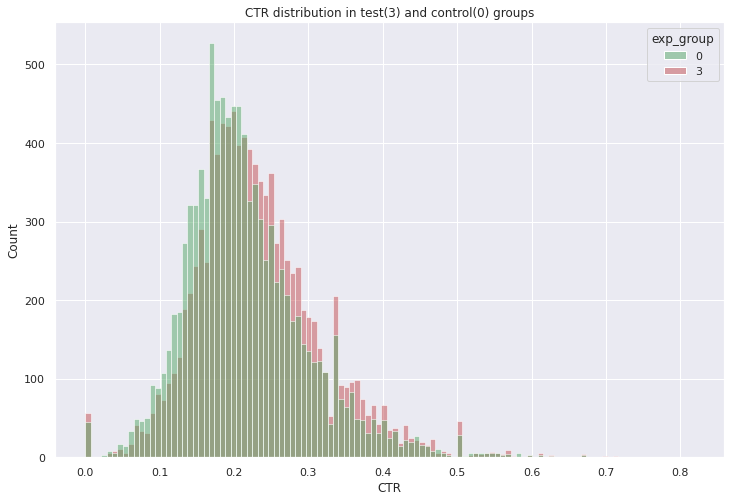

In [53]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'r'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(3) and control(0) groups')
plt.xlabel('CTR')
plt.show()

Distributions for both groups are normal, we can use Student's t-test

In [54]:
stats.ttest_ind(df[df.exp_group == 0].ctr,df[df.exp_group == 3].ctr)

Ttest_indResult(statistic=-13.895802293872993, pvalue=1.071239841805842e-43)

В результате t-теста Стьюдента p-value получился меньше 0.05, соответственно, мы не можем принять нулевую гипотезу, различия между средними значениями являются статистически значимыми.

Проанализируем тест между группами 0 и 3 по метрике линеаризованных лайков.

In [55]:
CTRcontrol_0 = (df[df.exp_group == 0]['likes'].sum())/(df[df.exp_group == 0]['views'].sum())
CTRcontrol_3 = (df[df.exp_group == 3]['likes'].sum())/(df[df.exp_group == 3]['views'].sum())

In [56]:
linearized_likes_0 = df[df.exp_group == 0]['likes'] - (CTRcontrol_0*(df[df.exp_group == 0]['views']))
linearized_likes_3 = df[df.exp_group == 3]['likes'] - (CTRcontrol_0*(df[df.exp_group == 3]['views']))

Сравним графики распределений CTR визуально

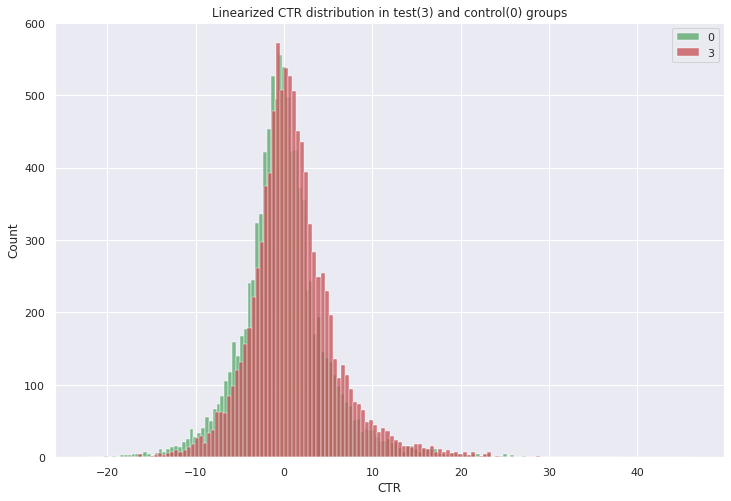

In [57]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(linearized_likes_0, color='g', label='0')
sns.histplot(linearized_likes_3, color='r', label='3')
plt.title('Linearized CTR distribution in test(3) and control(0) groups')
plt.xlabel('CTR')
plt.legend()
plt.show()

In [58]:
stats.ttest_ind(linearized_likes_0,linearized_likes_3,equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

Значение p-value оказалось еще меньше, чем при обычном t-тесте Стьюдента. Это подтверждает наличие статистически значимого различия между средними тестовой и контрольной группы.

Проведем сравнение тестов между группами 1 и 2

In [59]:
q2 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [60]:
df2 = ph.read_clickhouse(q2, connection=connection)

In [61]:
df2

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


Сравним графики распределений CTR визуально

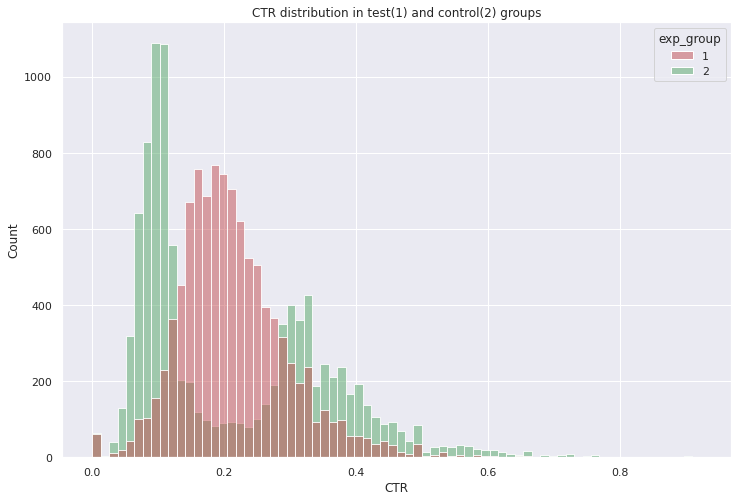

In [62]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data = df2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'g'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(1) and control(2) groups')
plt.xlabel('CTR')
plt.show()

Распределение CTR в первой группе нормальное, распределение CTR во второй группе - двугорбое. Проведем t-тест Стьюдента.

In [63]:
stats.ttest_ind(df2[df2.exp_group == 1].ctr,
                df2[df2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

При t-тесте Стьюдента p-value больше 0.05, соответственно, различия между средними значениями не являются статистически значимыми. Однако видно, что отличия в распределениях есть, ложноположительный результат t-теста Стьюдента вызван тем, что t-тест Стьюдента можно применять только к нормальным распределениям, в нашем случае только одно из распределений является нормальным.

Проанализируем группы 1 и 2 по метрике линеаризованных лайков.

In [64]:
CTRcontrol_1 = (df2[df2.exp_group == 1]['likes'].sum())/(df2[df2.exp_group == 1]['views'].sum())
CTRcontrol_2 = (df2[df2.exp_group == 2]['likes'].sum())/(df2[df2.exp_group == 2]['views'].sum())

In [65]:
linearized_likes_1 = df2[df2.exp_group == 1]['likes'] - (CTRcontrol_1*(df2[df2.exp_group == 1]['views']))
linearized_likes_2 = df2[df2.exp_group == 2]['likes'] - (CTRcontrol_1*(df2[df2.exp_group == 2]['views']))

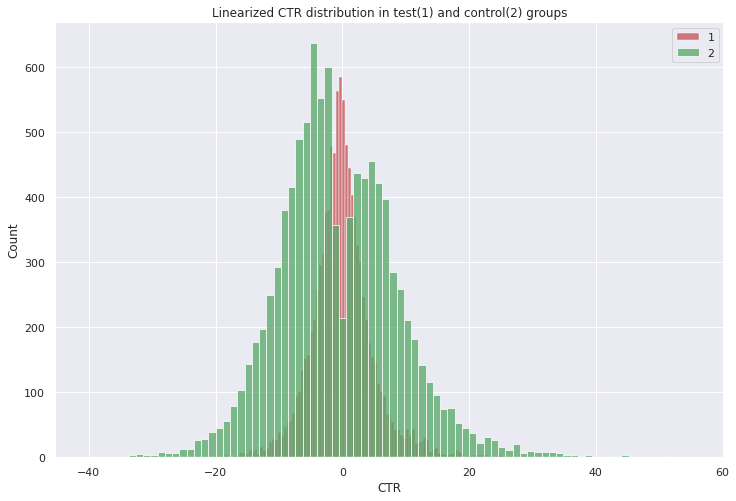

In [66]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(linearized_likes_1, color='r', label='1')
sns.histplot(linearized_likes_2, color='g', label='2')
plt.title('Linearized CTR distribution in test(1) and control(2) groups')
plt.xlabel('CTR')
plt.legend()
plt.show()

In [67]:
stats.ttest_ind(linearized_likes_1,
                linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

В случае использования методики линеаризованных лайков значение p-value меньше 0.05, соответственно, различия в группах статистически значимы. 

Вывод.
Чувствительность метрики линеаризованных лайков действительно выше стандартного t-теста Стьюдента.